In [16]:
import gurobipy as gb
import matplotlib.pyplot as plt
import numpy as np


In [17]:
''' 
   Parameters setting
'''

T = 5; n = 4
T = list(range(1,T+1)); S = list(range(n))

################ Adulyasak et al. 2014
# C = floor(2*sum(d)/len(T))
################ Archetti et al. 2011
# h0 = 8
# f = 100*10*8
# d = U[5, 25]

h = 8; f = 1e3*h

I0 = {s:0 for s in S[1:]}
d = {t:np.random.randint(5,25) for t in T}
C = np.floor(2*sum(list(d.values()))/len(T))

# Results functions

In [94]:
def print_model_results(m):
    
    print(f"Objective: {round(m.getObjective().getValue(),2)}", f"\tRuntime: {m.runTime}")


def plot_model_results(q,w,I, T,S,C,d):

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6), width_ratios=[5,0.4])
    fig.subplots_adjust(wspace=0.1)

    axes[0][0].bar(x = T, height = list(q.values()), color="royalblue")
    axes[0][0].set_ylim(0,C+5)
    axes[0][0].set_ylabel("Production quantity")

    cm = plt.get_cmap("RdYlGn")
    for t in T:
        for s in S:
            axes[1][0].bar(x = t, height = w[t,s], bottom = sum(w[t,ss] for ss in range(s)), color = cm(1-s/S[-1]*0.9))

    axes[1][0].set_ylim(0,C+5)
    axes[1][0].set_ylabel("Demand fulfillment")
    axes[1][0].set_xlabel("Time Period")

    for a in [0,1]:
        axes[a][0].spines[["top","right"]].set_visible(False)
        axes[a][1].spines[["bottom","top","left","right"]].set_visible(False)
        axes[a][1].set_xticks([]); axes[a][1].set_yticks([])

    axes[1][1].set_xlim(0.8,1.6), axes[1][1].set_ylim(-0.2,1.2)
    axes[1][1].set_ylabel("Product's age")
    for s in S:
        axes[1][1].bar(x=1,height=1/len(S),bottom=s/len(S),width=0.4,color=cm(1-s/S[-1]*0.9))
        axes[1][1].text(x=1.4,y=s/len(S)+1/(2*len(S)),s=s,va="center", ha="center")



def plot_model_results_comb(ax, q, w, I, T, S, C, d, cm, base = True):

    ax.set_ylim(0,C+5)
    ax.spines[["top","right"]].set_visible(False)
    if base: ax.set_ylabel("Base model")
    else: ax.set_ylabel("Other model"); ax.set_xlabel("Time period")

    ax.bar(x = [t-0.2 for t in T], height = list(q.values()), width=0.4, color="royalblue")
    for t in T:
        for s in S:
            ax.bar(x = t+0.2, height = w[t,s], bottom = sum(w[t,ss] for ss in range(s)), width=0.4, color = cm(1-s/S[-1]*0.9))


def compare_models(q,w,I,T,S,C,d):

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8), width_ratios=[6.25,1.75])
    fig.subplots_adjust(wspace=0.1)

    cm = plt.get_cmap("RdYlGn")
    
    ''' Legend '''
    axes[0][1].bar(x = 0.65, height=0.3, bottom=1.2, width=0.3, color="royalblue")
    axes[0][1].text(x=0.9, y=1.35, s="Production\nquantity", ha="left", va="center")
    axes[0][1].text(x=0.725,y=0.5,s="Product's age",va="center",ha="center",rotation=90)
    for s in S:
        axes[0][1].bar(x=1, height=1/len(S), bottom=s/len(S), width=0.3, color=cm(1-s/S[-1]*0.9))
        axes[0][1].text(x=1.275, y=s/len(S)+1/(2*len(S)), s=s, va="center", ha="center")
    axes[0][1].spines[["bottom","top","left","right"]].set_visible(False)
    axes[0][1].set_xticks([]); axes[0][1].set_yticks([])
    axes[0][1].set_xlim(0.4,1.5), axes[0][1].set_ylim(-0.2,1.7)

    ''' Metrics '''
    axes[1][1].spines[["bottom","top","left","right"]].set_visible(False)
    axes[1][1].set_xticks([]); axes[1][1].set_yticks([])
    axes[1][1].set_xlim(0, 5); axes[1][1].set_ylim(0,10)
    
    plot_model_results_comb(axes[0][0], q[0], w[0], I[0], T, S, C, d, cm)
    plot_model_results_comb(axes[1][0], q[1], w[1], I[1], T, S, C, d, cm, base = False)



# Models

In [95]:

def base_model(T,S,n,f,h,C,I0,d, output=False, verbose=False):

    m = gb.Model("Base")

    ################################
    # DECISION VARIABLES
    ################################

    # Whether there is a setup programmed for period t \in T or not
    y = {t:m.addVar(name=f"y_{t}", vtype=gb.GRB.BINARY) for t in T}
    # Production quantity in period t \in T
    q = {t:m.addVar(name=f"q_{t}", vtype=gb.GRB.CONTINUOUS) for t in T}
    # Consumption of product of age s \in S in period t \in T
    w = {(t,s):m.addVar(name=f"w_{t,s}", vtype=gb.GRB.CONTINUOUS) for t in T for s in S}
    # Available inventory of product of age s \in S at the end of period t \in T
    I = {(t,s):m.addVar(name=f"I_{t,s}", vtype=gb.GRB.CONTINUOUS) for t in T for s in S}

    ################################
    # CONSTRAINTS
    ################################

    # Inventory modeling of aged product in first period, using available initial inventory
    for s in S[1:]:
        m.addConstr(I[1,s] == I0[s] - w[1,s])

    for t in T:

        # Inventory modeling of fresh product
        m.addConstr(I[t,0] == q[t] - w[t,0])

        # Inventory dynamics throughout the days
        if t > 1:
            for s in S[1:]:
                m.addConstr(I[t,s] == I[t-1,s-1] - w[t,s])
        
        # Production capacity
        m.addConstr(q[t] <= C*y[t])

        # Demand fulfillment
        m.addConstr(gb.quicksum(w[t,s] for s in S) == d[t])
        
    ################################
    # OBJECTIVE FUNCTION
    ################################

    m.setObjective(gb.quicksum(f*y[t] + h*gb.quicksum(I[t,s] for s in S) for t in T))

    m.update()
    m.setParam("OutputFlag", output)
    m.optimize()

    ################################
    # DECISIONS RETRIEVAL
    ################################

    q = {t:q[t].x for  t in T}
    w = {(t,s):w[t,s].x for t in T for s in S}
    I = {(t,s):I[t,s].x for t in T for s in S}

    ################################
    # RESULTS
    ################################

    if verbose: print_model_results(m)

    return q, w, I


def other_model(T,S,n,f,h,C,I0,d, output=False, verbose=False):
    
    Tt = {t:[m for m in range(t,np.min((T[-1],t+n-1))+1)] for t in T}
    mm = gb.Model("Transportation")

    ################################
    # DECISION VARIABLES
    ################################

    # Whether there is a setup programmed for period t \in T or not
    y = {t:mm.addVar(name=f"y_{t}", vtype=gb.GRB.BINARY) for t in T}
    # Amount of product that is produced in period t \in T and used to fulfill demand in m \in T_t
    q = {(t,m):mm.addVar(name=f"q_{t,m}", vtype=gb.GRB.CONTINUOUS) for t in T for m in Tt[t]}
    # Amount of the initial inventory aged s \in S that is used to fulfill demand in t \in {1, ..., n-s}
    b = {(t,s):mm.addVar(name=f"b_{t,s}", vtype=gb.GRB.CONTINUOUS) for s in S for t in range(1,n-s+1)}
    # Total available inventory at the end of t \in T
    I = {t:mm.addVar(name=f"I_{t}", vtype=gb.GRB.CONTINUOUS) for t in T}

    ################################
    # CONSTRAINTS
    ################################

    # Initial inventory availability
    for s in S:
        mm.addConstr(gb.quicksum(b[t,s] for t in range(1,n-s+1)) <= I0[s])

    for t in T:
        
        # For periods in which initial inventory can be used
        if t <= n-1:
            # Inventory modeling
            mm.addConstr(I[t] == gb.quicksum(I0[s]-gb.quicksum(b[j,s] for j in range(1,np.min((t,n-s))+1)) for s in S) + gb.quicksum(q[j,m] for j in range(np.max((1,t-n+2)),t+1) for m in range(t+1,np.min((T[-1],j+n-1))+1)))
            # Demand fulfillment
            mm.addConstr(gb.quicksum(b[t,s] for s in S if t<=(n-s)) + gb.quicksum(q[j,t] for j in range(np.max((1,t-n+1)),t+1)) == d[t])
        else:
            # Inventory modeling
            if t < T[-1]:
                mm.addConstr(I[t] == gb.quicksum(q[j,m] for j in range(np.max((1,t-n+2)),t+1) for m in range(t+1,np.min((T[-1],j+n-1))+1)))
            # Demand fulfillment
            mm.addConstr(gb.quicksum(q[j,t] for j in range(np.max((1,t-n+1)),t+1)) == d[t])
        
        # Production capacity
        mm.addConstr(gb.quicksum(q[t,m] for m in Tt[t]) <= C*y[t])
        
    ################################
    # OBJECTIVE FUNCTION
    ################################

    mm.setObjective(gb.quicksum(f*y[t]+h*I[t] for t in T))

    mm.update()
    mm.setParam("OutputFlag", output)
    mm.optimize()

    ######################################
    # DECISIONS RETRIEVAL AND TRANSLATION
    ######################################

    qq = {t:sum(q[t,m].x for m in Tt[t]) for  t in T}
    w = {(t,s):q[t-s,t].x for s in S+[0] for t in T if t-s>=1 and t in Tt[t-s]}
    w.update({(t,t+s-1):b[t,s].x for s in S for t in range(1,n-s+1)})
    I = {(1,s):I0[s]-w[1,s] for s in S}
    for t in T:
        I[t,0] = qq[t] - w[t,0]
        for s in S:
            if t>1: I[t,s] = I[t-1,s-1] - w[t,s]
    
    ################################
    # RESULTS
    ################################

    if verbose: print_model_results(mm)
    
    return qq, w, I


Objective: 24320.0 	Runtime: 0.009999990463256836
Objective: 24320.0 	Runtime: 0.003999948501586914


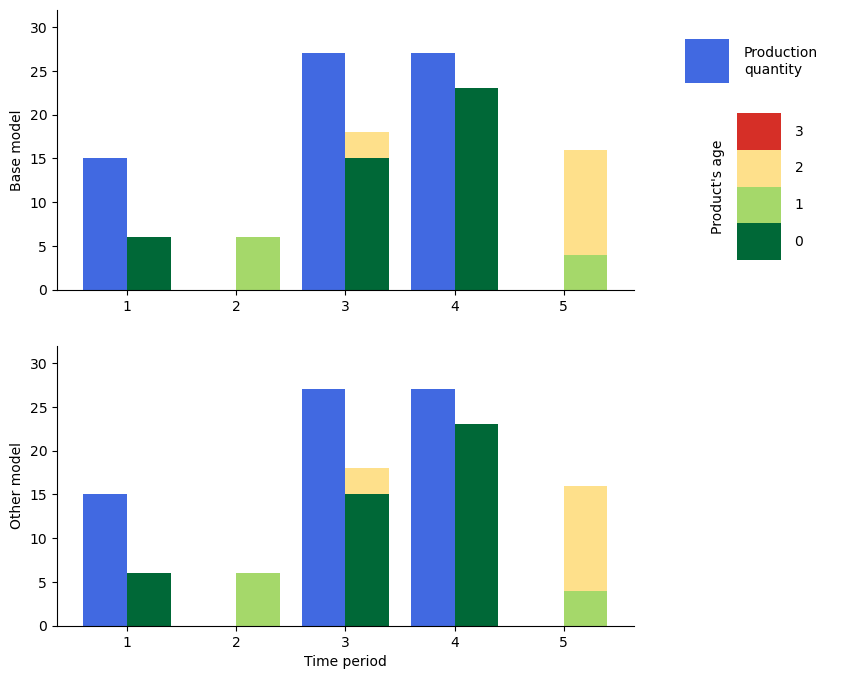

In [96]:
q1,w1,I1 = base_model(T, S, n, f, h, C, I0, d, verbose=True)
q2,w2,I2 = other_model(T, S[1:], n, f, h, C, I0, d, verbose=True)
compare_models((q1,q2), (w1,w2), (I1,I2), T, S, C, d)